In [10]:
import os
import sys
import json
import glob

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_module.data_module import FFTDataModule
from model.AE_model import AECNN1DModel

In [2]:
PREDICT = True

random_seed = 42
L.seed_everything(random_seed)

Seed set to 42


42

In [3]:
n_epochs = 20000
patience = n_epochs//100

optimizer_param_dict = {
    "Adam": (optim.Adam, {
        "lr": 0.001,
    }),
    "SGD": (optim.SGD, {
        "lr": 0.001,
        "momentum": 0.5,
    }),
}
batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = "/nfs/ksdata/tran/HAR_AE/dataset/processed_concat_data"

log_save_dir = "lightning_logs/14_AE_5classes"

In [4]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.utilities.model_summary import ModelSummary

def train_one_model(net, model_name):
    
    tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=model_name,)
    csv_logger = CSVLogger(save_dir=log_save_dir, name=model_name,)
    checkpoint_callback = ModelCheckpoint(
        dirpath=None,
        save_top_k=1,
        monitor="val_mse",
        mode="min",
        filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
    )

    trainer = L.Trainer(
        logger=[tensorboard_logger, csv_logger],
        callbacks=[EarlyStopping(monitor="val_mse", patience=patience), checkpoint_callback],
        max_epochs=n_epochs,
        check_val_every_n_epoch=10,
        accelerator="auto"
        )

    data_module = FFTDataModule(dataset_path=dataset_path, batch_size=batch_size)

    trainer.fit(model=net, datamodule=data_module)
    trainer_test_dict = trainer.logged_metrics
    
    trainer.test(model=net, datamodule=data_module)
    trainer_test_dict.update(trainer.logged_metrics)

    for key in trainer_test_dict.keys():
        trainer_test_dict[key] = trainer_test_dict[key].item()
    
    with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
        json.dump(trainer_test_dict, f, indent=4)

In [5]:
run_filter_list = [ # CNN filter, Linear filter
    ((16, 32), (256, 128)),
    ((32, 64), (256, 128)),
    ((64, 128), (256, 128)),
    ((16, 32, 64), (256, 128)),
    ((32, 64, 128), (256, 128)),
    ((16, 32), (512, 256)),
    ((32, 64), (512, 256)),
    ((64, 128), (512, 256)),
    ((16, 32, 64), (512, 256)),
    ((32, 64, 128), (512, 256)),
    ((16, 32), (128, 64)),
    ((32, 64), (128, 64)),
    ((64, 128), (128, 64)),
    ((16, 32, 64), (128, 64)),
    ((32, 64, 128), (128, 64)),
    ((16, 32), (256, 128, 64)),
    ((32, 64), (256, 128, 64)),
    ((64, 128), (256, 128, 64)),
    ((16, 32, 64), (256, 128, 64)),
    ((32, 64, 128), (256, 128, 64)),
    ((16, 32), (512, 256, 128)),
    ((32, 64), (512, 256, 128)),
    ((64, 128), (512, 256, 128)),
    ((16, 32, 64), (512, 256, 128)),
    ((32, 64, 128), (512, 256, 128)),
    ((16, 32), (128, 64, 32)),
    ((32, 64), (128, 64, 32)),
    ((64, 128), (128, 64, 32)),
    ((16, 32, 64), (128, 64, 32)),
    ((32, 64, 128), (128, 64, 32)),
]

In [6]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--idx", type=int, default=0,
                    help=f"learning pattern min=0, max={len(run_filter_list) - 1}")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

In [7]:
def create_model(cnn_filters, linear_filters):
    assert len(cnn_filters) > 0 and len(linear_filters) > 0

    first_input_channel = 6
    cnn_channel_param = [(first_input_channel, cnn_filters[0], 8, 0, 3)]
    for cnn_filter_idx in range(len(cnn_filters) - 1):
        in_c, out_c = cnn_filters[cnn_filter_idx], cnn_filters[cnn_filter_idx + 1]
        cnn_channel_param.append((in_c, out_c, 8, 0, 3))

    linear_channel_param = linear_filters
    net = AECNN1DModel(
        optimizer = optimizer,
        optimizer_param = optimizer_param, 
        cnn_channel_param = cnn_channel_param,
        linear_channel_param = linear_channel_param,
    )

    return net
    

In [9]:
if not PREDICT:
    cnn_filters, linear_filters = run_filter_list[args.idx]
    net = create_model(cnn_filters, linear_filters)
    model_summary = ModelSummary(net, max_depth=6)
    print(model_summary)

    train_one_model(net, model_name=f"pattern_{args.idx}")


In [12]:
def calculate_rc(linear_filters):
    last_linear_node = linear_filters[-1]
    rc = 100 * last_linear_node / ( 257 * 6 )
    return rc

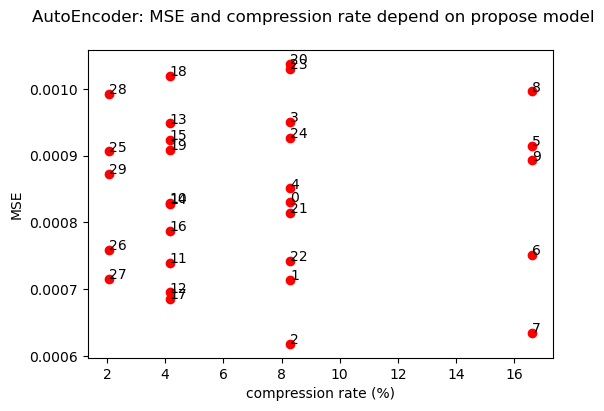

In [28]:
if PREDICT:
    result_list = []
    
    for run_idx, run_filter in enumerate(run_filter_list):
        result_file_path = os.path.join(log_save_dir, f"pattern_{run_idx}", "version_0", "result.json")
        with open(result_file_path) as f:
            result_dict = json.load(f)

        cnn_filters, linear_filters = run_filter
        rc = calculate_rc(linear_filters)

        result_list.append((rc, result_dict["test_mse"]))

    fig, ax = plt.subplots(figsize=(6, 4))

    x = [_[0] for _ in result_list]
    y = [_[1] for _ in result_list]
    
    ax.scatter(x, y, color="red")
    fig.suptitle("AutoEncoder: MSE and compression rate depend on propose model")
    ax.set_xlabel("compression rate (%)")
    ax.set_ylabel("MSE")

    for run_idx, run_filter in enumerate(run_filter_list):
        ax.annotate(str(run_idx), (x[run_idx], y[run_idx]))


In [29]:
print(run_filter_list[2])
print(run_filter_list[17])
print(run_filter_list[27])

((64, 128), (256, 128))
((64, 128), (256, 128, 64))
((64, 128), (128, 64, 32))
